### Intern take-home Assessment:

In [436]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns

* The question is:
"predict what profits MIGHT have been at each of the three candidate locations IF 
the locations had been open and operating during appropriate time periods 
from January 1st through October 30th of 2022. 
Based on these predictions, which location would have likely been the most profitable 
in the first 10 months of 2022 if it had been open for business?

This actually sounds more like hypothetical causal predictions regarding the profits, with Locations as the "intervention/Treatment/Exposure" variable.

### Data preprocessing:

In [272]:
#import all dataset with different format:
directory = "data"
dta_transac = []
dta_other = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        data_type = f.split('.')[0].split('_')[0].split('/')[1] #i.e. transactions, weather, holiday, location
        if data_type == 'transactions' and f.split('.')[-1] == 'txt':
            dta = pd.read_csv(f, sep = "\t")
            dta_transac.append(dta)
        elif data_type == 'transactions' and f.split('.')[-1] == 'json':
            dta = pd.read_json(f)
            dta_transac.append(dta)
        elif data_type == 'transactions' and f.split('.')[-1] == 'csv':
            dta = pd.read_csv(f)
            dta_transac.append(dta)
        else:
            dta = pd.read_csv(f)
            dta_other.append(dta)

In [273]:
#concatenate all of the transaction data together
data_transac = pd.concat(dta_transac)

In [286]:
data_weather = dta_other[0]
data_holiday = dta_other[1]
data_location = dta_other[2]
data_weather['day_of_year'] = pd.to_datetime(data_weather['date']).dt.dayofyear
data_weather['week_of_year'] = pd.to_datetime(data_weather['date']).dt.isocalendar().week
data_weather['week_of_year'] = data_weather['week_of_year'].astype(int)
data_weather['weekdays'] = pd.to_datetime(data_weather['date']).dt.dayofweek
data_weather['month'] = pd.to_datetime(data_weather['date']).dt.month
data_weather['year'] = pd.to_datetime(data_weather['date']).dt.year
data_weather['snow'] = np.where(data_weather['temperature'] < 32, 1, 0) #1 means snow, 0 means river
#if the temperature is lower than 32F then it will be snow type

In [287]:
#unify the format of the profit data using regular expression.
profit = []
for i in data_transac.profit:#.str[2:]:
    #print(i)
    #print(type(str(i)))
    res = re.sub('[-$]', '', str(i))
    profit.append(float(str(res)))
data_transac['profit'] = profit

##### Concatenate all other variables except transactions:

In [355]:
#formalize the date variable
data_weather['date'] = pd.to_datetime(data_weather['date']).dt.strftime('%m-%d-%Y') #location data
data_holiday['date'] = pd.to_datetime(data_holiday['date']).dt.strftime('%m-%d-%Y') #holiday data

In [356]:
#firstly, combine the holiday with the location data:
dta = data_weather.merge(data_holiday, how = 'left', on = 'date')
dta = dta.fillna(0) #fill out the holiday indicator to be 0 for missing values in holiday
dta.holiday = dta.holiday.astype(int)

In [357]:
#secondly, combine the merged data with location data (i.e., population, elevation)
dta = dta.merge(data_location, how = 'left', on = 'location_id')

In [358]:
#thirdly, aggregate the profits for each location for each date:
dta_tran_agg = (data_transac
    .groupby(['location_id', 'date'])
    ['profit'].sum()
    .reset_index(level=[0,1]))
dta_tran_agg['date'] = pd.to_datetime(dta_tran_agg.date).dt.strftime('%m-%d-%Y')

In [359]:
#change the format to make sure that the transaction data and other information are using the same date format
dta['date'] = pd.to_datetime(dta.date).dt.strftime('%Y-%m-%d')
dta_tran_agg['date'] = pd.to_datetime(dta_tran_agg.date).dt.strftime('%Y-%m-%d')

In [360]:
#merge the aggregated transaction data with the other characteristics of the different location
final_data = dta_tran_agg.merge(dta, on = ['location_id', 'date'], how = 'left')
#use last observation carry forward for the missing data:
final_data = final_data.sort_values(['location_id', 'date'], ascending = [True, True])
final_data = final_data.ffill(axis = 0)

In [361]:
#drop holiday because they are all non holidays:
dta = dta.drop(['holiday'], axis = 1)
final_data = final_data.drop(['holiday'], axis = 1)

### Exploratory data analysis

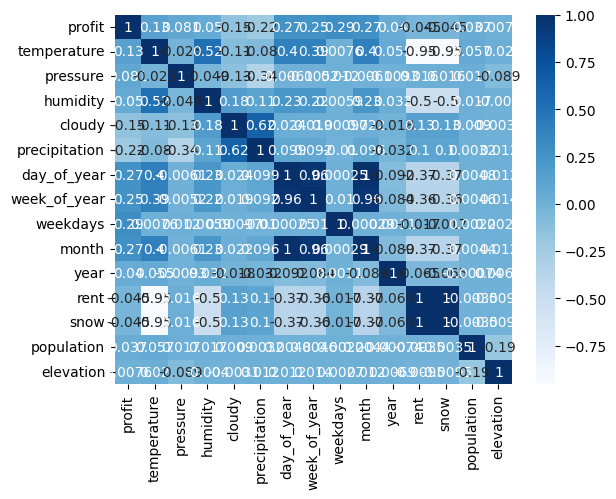

In [296]:
#Firstly, we can draw the correlation plot
corr = final_data.iloc[:, 2:].corr()
sns.heatmap(corr, cbar = True,annot = True,cmap = 'Blues')
plt.show()

* We can see that the most correlated variable to profit would be time variables. Temperature and precipitation is also correlated with the profits.

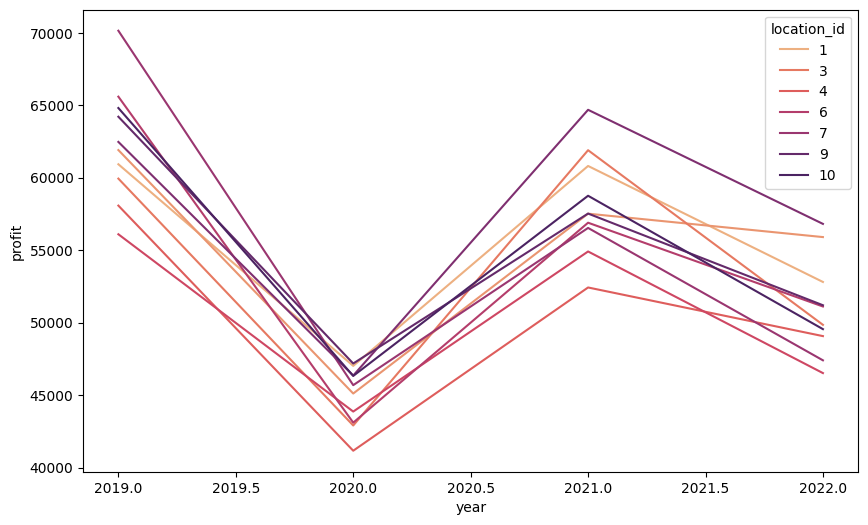

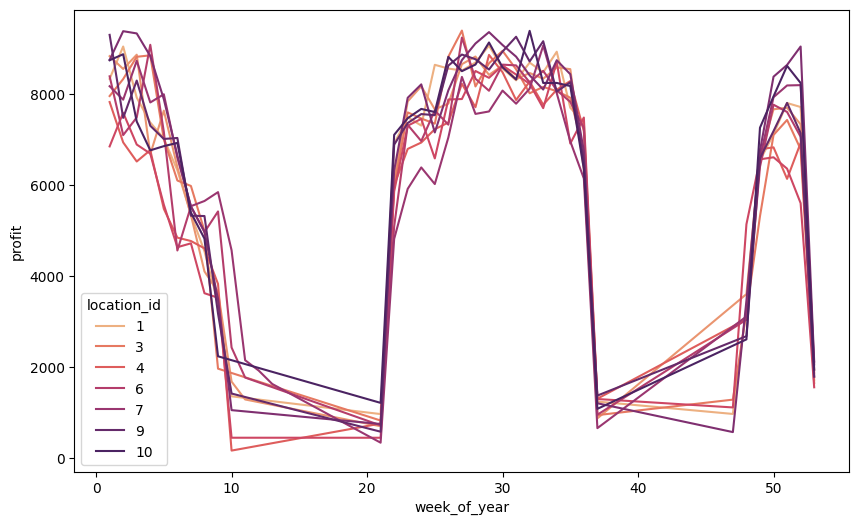

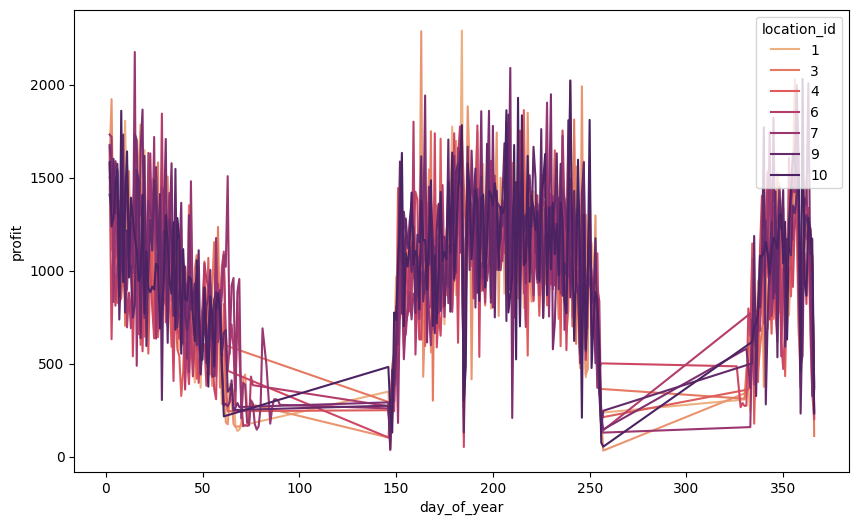

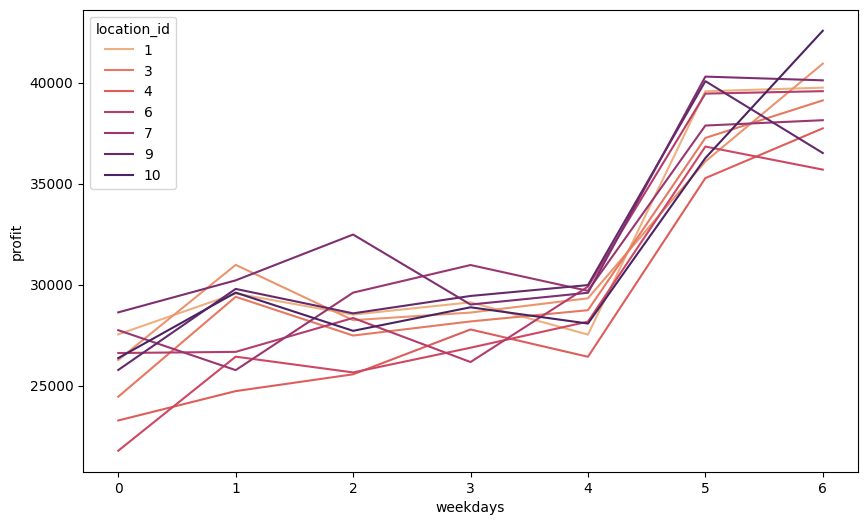

In [309]:
#Profit plot over time variables:
plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'year'])['profit'].sum().reset_index(), x='year', y='profit', hue='location_id',palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'week_of_year'])['profit'].sum().reset_index(), x='week_of_year', y='profit', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'day_of_year'])['profit'].sum().reset_index(), x='day_of_year', y='profit', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'weekdays'])['profit'].sum().reset_index(), x='weekdays', y='profit', hue='location_id', palette = "flare")
plt.show()


* Obviously profit is good in the winter time and summer time. 
* Weekends always have larger profits. 

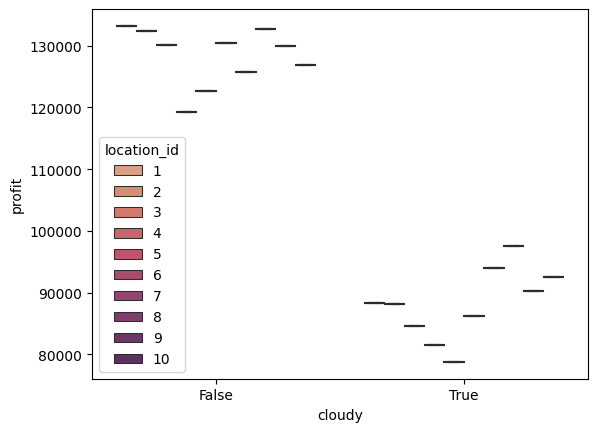

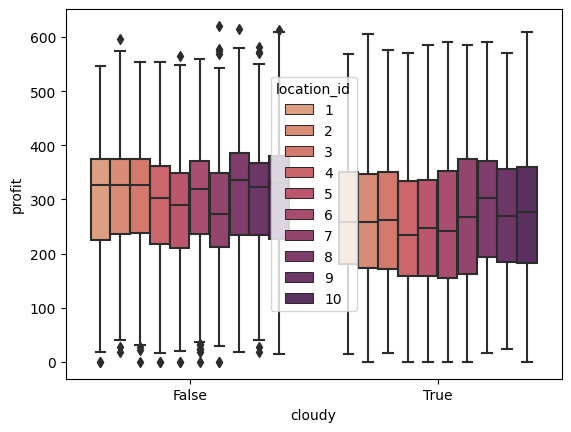

In [259]:
# Cloudy day profit:
sns.boxplot(data= final_data.groupby(['location_id', 'cloudy'])['profit'].sum().reset_index(), x='cloudy', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='cloudy', y='profit', hue='location_id', palette = "flare")
plt.show()

* First plot is the aggregated profits for the cloudy and non cloudy days. Obviously the non-cloudy days have larger profits.
* Second plot is the non aggregated profits based on the cloudy condition. We also can observe that the non-cloudy day has larger profits

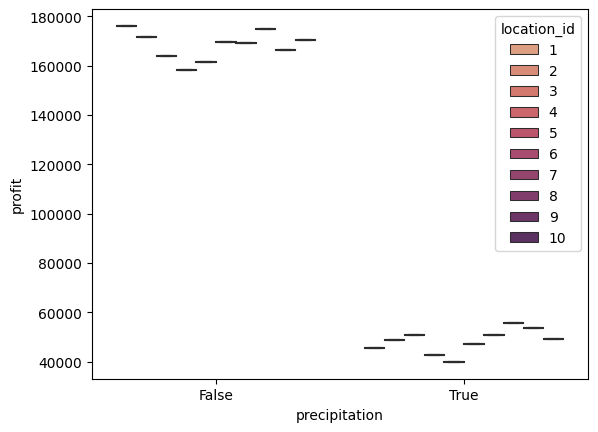

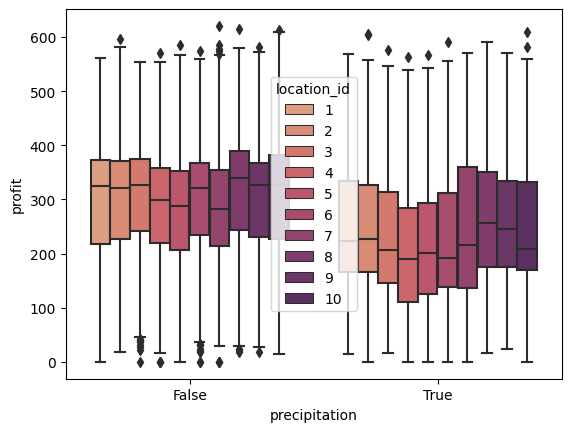

In [261]:
# Precipitation profit:
sns.boxplot(data= final_data.groupby(['location_id', 'precipitation'])['profit'].sum().reset_index(), x='precipitation', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='precipitation', y='profit', hue='location_id', palette = "flare")
plt.show()

* Similar to cloudy condition where non-rainy day has larger profits for each location

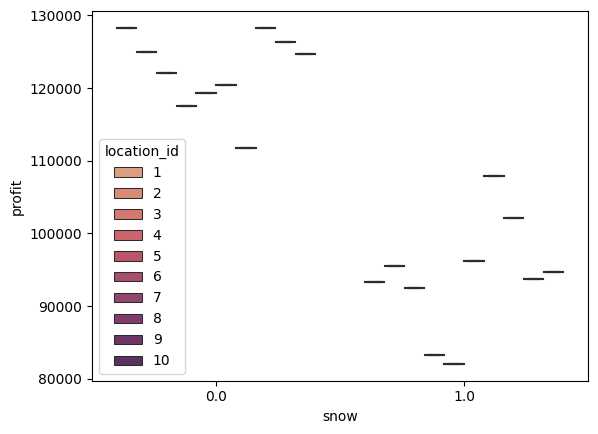

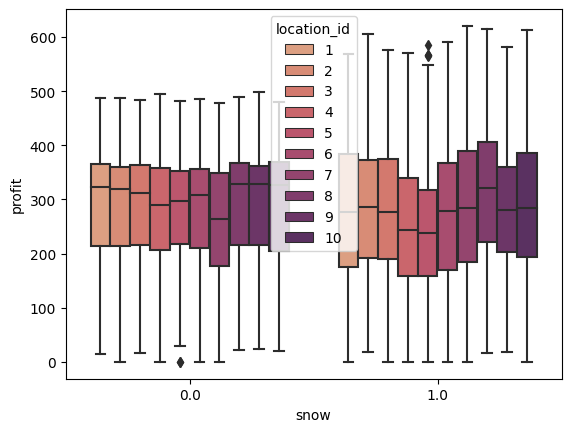

In [313]:
# Snow/River vs profit:
sns.boxplot(data= final_data.groupby(['location_id', 'snow'])['profit'].sum().reset_index(), x='snow', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='snow', y='profit', hue='location_id', palette = "flare")
plt.show()

* aggregated snow/river shows that river has larger profits, and the box plot also shows it too

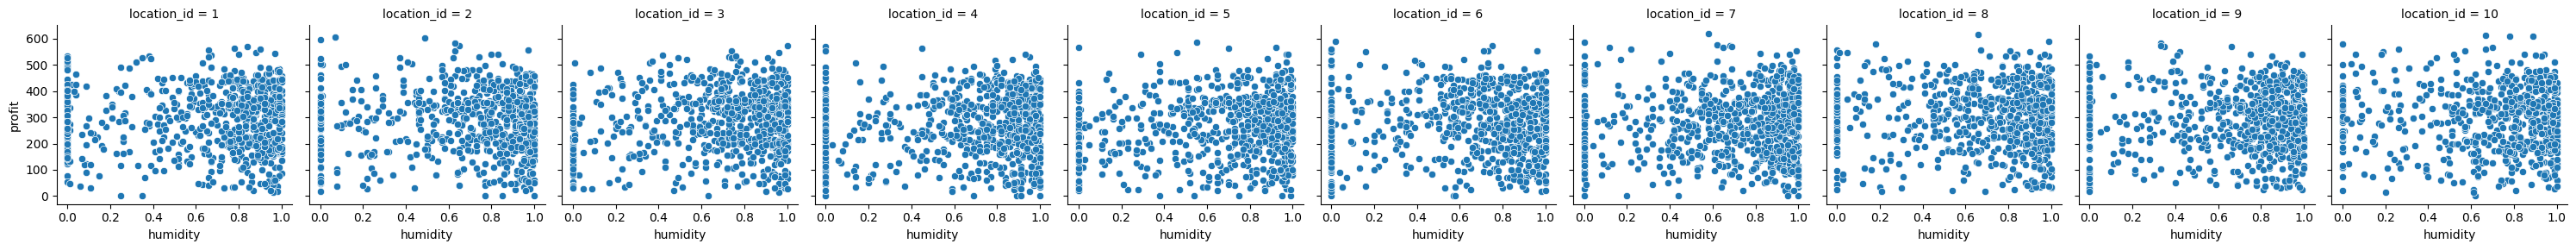

In [305]:
# Humidity vs profits:

g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'humidity', y = "profit")
plt.show()

* Did not observe obvious linear relationship between humidity vs profit

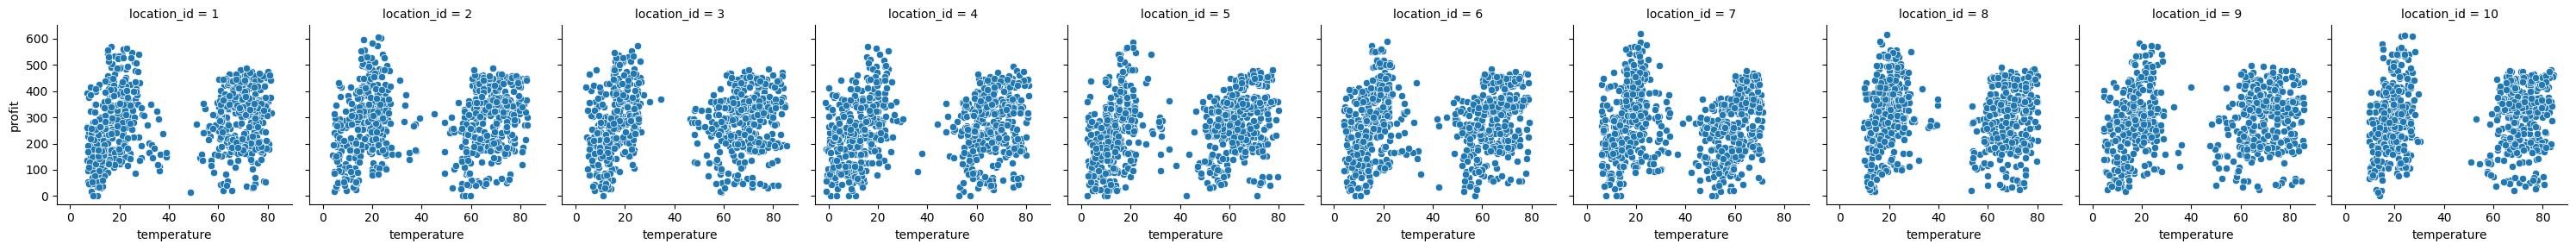

In [311]:
g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'temperature', y = "profit")
plt.show()

* Here we can see that the temperature around 30 F can give us the largest profit, and there is obvious linear relationship between temperature and profit.

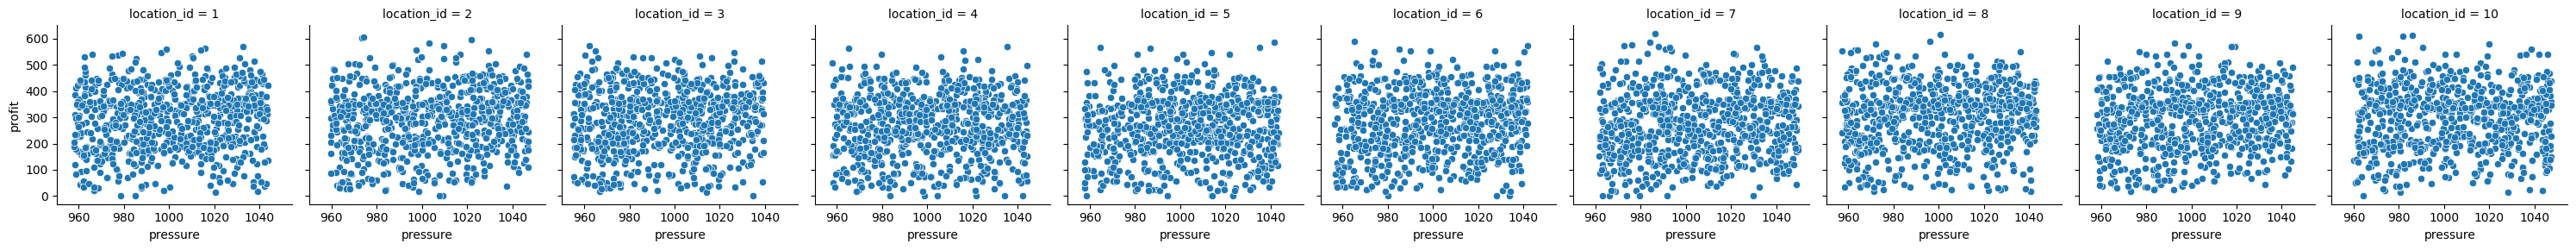

In [314]:
# Pressure vs profit
g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'pressure', y = "profit")
plt.show()

* No obvious lineary relationship between pressure and profits

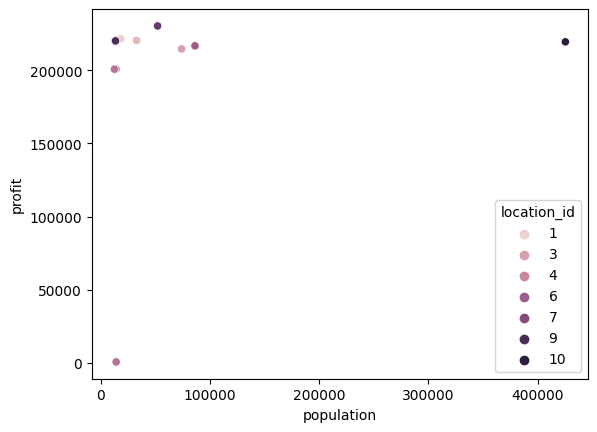

In [325]:
# Population vs profit
sns.scatterplot(data = final_data.groupby(['location_id', 'population']).agg({'profit': np.sum}).reset_index(), x = 'population', y = 'profit', hue = 'location_id')
plt.show()

* We thought that larger population means larger profits. But it didn't show us such trend where one location with more than 400000 population has simlar profits with other locations

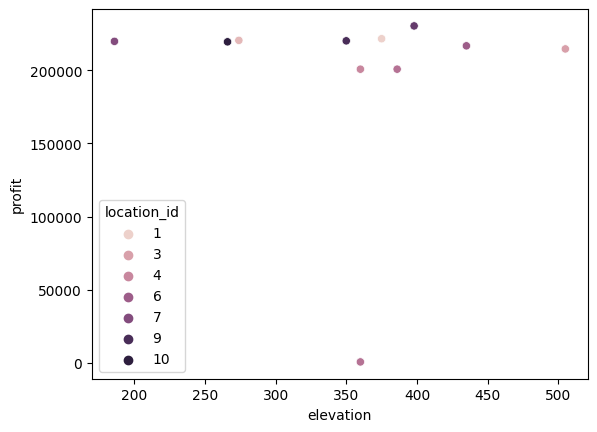

In [329]:
#Elevation vs profit
sns.scatterplot(data = final_data.groupby(['location_id', 'elevation']).agg({'profit': np.sum}).reset_index(), x = 'elevation', y = 'profit', hue = 'location_id')
plt.show()

In [330]:
final_data

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,day_of_year,week_of_year,weekdays,month,year,rent,snow,population,elevation
0,1,2019-01-02,430.96,16.88,1034.166667,0.44,False,False,2.0,1.0,2.0,1.0,2019.0,1.0,1.0,18428.0,375.0
1,1,2019-01-03,416.90,17.24,1015.657277,0.58,False,False,3.0,1.0,3.0,1.0,2019.0,1.0,1.0,18428.0,375.0
2,1,2019-01-04,280.16,9.32,1028.145540,0.00,True,False,4.0,1.0,4.0,1.0,2019.0,1.0,1.0,18428.0,375.0
3,1,2019-01-05,415.98,20.12,1035.950704,0.87,True,False,5.0,1.0,5.0,1.0,2019.0,1.0,1.0,18428.0,375.0
4,1,2019-01-06,412.20,17.24,981.091549,0.80,False,False,6.0,1.0,6.0,1.0,2019.0,1.0,1.0,18428.0,375.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7637,10,2022-09-07,432.25,65.30,1046.431925,0.93,False,False,250.0,36.0,2.0,9.0,2022.0,0.0,0.0,425336.0,266.0
7638,10,2022-09-08,405.04,65.30,1046.431925,0.93,False,False,250.0,36.0,2.0,9.0,2022.0,0.0,0.0,425336.0,266.0
7639,10,2022-09-09,124.59,57.74,969.941315,0.97,True,True,252.0,36.0,4.0,9.0,2022.0,0.0,0.0,425336.0,266.0
7640,10,2022-09-10,374.87,61.70,972.171362,0.83,False,False,253.0,36.0,5.0,9.0,2022.0,0.0,0.0,425336.0,266.0


* Non obvious linear relationship between elevation vs profit.

### Modeling

In [368]:
#define X and y data:
X = np.array(final_data.iloc[:, 3:])
y = np.array(final_data.iloc[:, 2])

In [373]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#split the data to training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [427]:
#Save the prediction result for each method:
model_names = []
fitted_model = []
MSEs = []
R2 = []

In [428]:
models = {'Linear Regression' : LinearRegression(),
          'Lasso': LassoCV(cv = 5, random_state = 1, max_iter = 100000),
          'Elastic Net': ElasticNetCV(cv = 5, random_state = 1, max_iter = 100000),
          'Random Forest': RandomForestRegressor(random_state=0),
          'Gradient Boosting': GradientBoostingRegressor(random_state=0)}

In [429]:
for model_name, model in models.items():
    print(model_name)
    regressor = model.fit(X_train, y_train)
    fitted_model.append(regressor)
    y_pred = model.predict(X_test)
    print('MSE', mean_squared_error(y_test, y_pred))
    print('R2_score', r2_score(y_test, y_pred))
    model_names.append(model_name)
    MSEs.append(mean_squared_error(y_test, y_pred))
    R2.append(r2_score(y_test, y_pred))

Linear Regression
MSE 9393.67228023495
R2_score 0.3100062080709398
Lasso
MSE 9422.074100456115
R2_score 0.30792000801547026
Elastic Net
MSE 9569.599427546145
R2_score 0.29708382416662515
Random Forest
MSE 2944.8830388326637
R2_score 0.7836893864152453
Gradient Boosting
MSE 2760.3662271371304
R2_score 0.7972427072868222


In [430]:
pd.DataFrame({'Model Name': model_names, 'MSE': MSEs, 'R2 Score': R2})

,Model Name,MSE,R2 Score
0,Linear Regression,9393.672280,0.310006
1,Lasso,9422.074100,0.307920
2,Elastic Net,9569.599428,0.297084
3,Random Forest,2944.883039,0.783689
4,Gradient Boosting,2760.366227,0.797243


* Here we can see the best peformance model is the GradientBoosting

In [411]:
#Use the GradientBoosting model for new location prediction

In [431]:
model_names.index('Gradient Boosting')

4

In [432]:
fitted_model[model_names.index('Gradient Boosting')]

GradientBoostingRegressor(random_state=0)

In [412]:
#retrieve the data to be predicted from location 11, 12, 13:
data_new = dta.loc[dta.location_id.isin([11, 12, 13])]

In [413]:
X_new = scaler.transform(np.array(data_new.iloc[:, 2:]))

In [433]:
#predict the profit:
data_new.loc[:, 'predicted_profit'] = fitted_model[model_names.index('Gradient Boosting')].predict(X_new)

/var/folders/wx/yg6t278534bcmkcnbt_lz9zw0000gn/T/ipykernel_64079/3964129849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new.loc[:, 'predicted_profit'] = fitted_model[model_names.index('Gradient Boosting')].predict(X_new)


In [434]:
data_new.groupby('location_id')['predicted_profit'].sum()

location_id
11    349716.864047
12    351156.339328
13    331144.776071
Name: predicted_profit, dtype: float64

In [435]:
data_new

,location_id,date,temperature,pressure,humidity,cloudy,precipitation,day_of_year,week_of_year,weekdays,month,year,rent,snow,population,elevation,predicted_profit
21,13,2022-06-27,77.54,987.112676,0.97,False,False,178,26,0,6,2022,0,0,68818,310,369.313425
26,13,2020-09-25,59.54,1012.758216,0.99,True,True,269,39,4,9,2020,0,0,68818,310,60.878331
30,13,2020-03-27,31.28,965.927230,0.24,True,True,87,13,4,3,2020,1,1,68818,310,95.439803
31,12,2022-04-29,47.12,979.084507,0.99,False,False,119,17,4,4,2022,0,0,196528,436,219.034589
44,11,2019-05-30,65.66,981.537559,0.92,True,True,150,22,3,5,2019,0,0,121465,398,180.948754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17247,11,2021-12-30,24.26,1030.598592,0.95,False,False,364,52,3,12,2021,1,1,121465,398,403.246311
17253,11,2019-10-04,48.02,986.666667,0.93,False,False,277,40,4,10,2019,0,0,121465,398,251.293597
17256,11,2021-07-01,72.50,1031.713615,0.77,False,False,182,26,3,7,2021,0,0,121465,398,366.418272
17258,12,2022-05-11,61.70,1022.570423,0.76,True,True,131,19,2,5,2022,0,0,196528,436,171.106622


##### KNN regression:

In [446]:
# Lastly, we want to try the KNN regression model for the prediction:
n_neighbors = 5
for i, weights in enumerate(["uniform", "distance"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    print('MSE', mean_squared_error(y_test, y_pred))
    print('R2_score', r2_score(y_test, y_pred))

MSE 7028.911009167976
R2_score 0.4837051138613465
MSE 7200.47744236931
R2_score 0.471103037667842


In [439]:
X_train, y_train

(array([[-0.667575  ,  1.40295647,  0.94347135, ...,  1.11846202,
          2.96801183, -0.99373778],
        [ 1.33028253, -1.37498366,  0.61512433, ..., -0.8940849 ,
          0.1101408 ,  0.94493391],
        [ 1.03506647,  1.38520606,  0.97630605, ..., -0.8940849 ,
          2.96801183, -0.99373778],
        ...,
        [ 1.350879  , -1.55248782,  0.94347135, ..., -0.8940849 ,
         -0.50306833, -0.03013765],
        [ 1.43326488, -0.94897367,  0.31961201, ..., -0.8940849 ,
          0.00699358,  1.74793402],
        [ 0.49269277,  1.23432752,  0.87780194, ..., -0.8940849 ,
         -0.50510025, -1.91145219]]),
 array([419.32, 280.21, 348.95, ..., 191.65, 440.24, 122.96]))

In [447]:
#predict the profit:
data_new.loc[:, 'predicted_profit'] = knn.fit(X_train, y_train).predict(X_new)

/var/folders/wx/yg6t278534bcmkcnbt_lz9zw0000gn/T/ipykernel_64079/596479445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new.loc[:, 'predicted_profit'] = knn.fit(X_train, y_train).predict(X_new)


In [448]:
data_new.groupby('location_id')['predicted_profit'].sum()

location_id
11    361384.210954
12    357478.706779
13    352299.881500
Name: predicted_profit, dtype: float64